<a href="https://colab.research.google.com/github/yashmehra028/so-fifa/blob/main/diff_script_so_fifa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import requests
from bs4 import BeautifulSoup as bs
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures
import pandas as pd
import re
from threading import Thread
import collections

In [ ]:
def get_player_links(offset_value):
    player_links = []
    r = requests.get(f'https://sofifa.com/players?offset={offset_value}')
    all_players_page = bs(r.content)
    tables = all_players_page.select('td.col-name')
    for table in tables:
        a_tag = table.find('a')
        url = a_tag['href']
        if 'player' in url and 'players' not in url:
            player_links.append('https://sofifa.com' + url)

    counter = collections.Counter(player_links)
    return [i[0] for i in counter.most_common()]

In [ ]:
def real_func(n_pages):
    with concurrent.futures.ThreadPoolExecutor() as Executor:
        results = Executor.map(get_player_links,range(0,60*n_pages,60))
        result = []
        for i in results:  
            result += i

        a = collections.Counter(result)
        return [i[0] for i in a.most_common()]



In [103]:
def get_name(player_page):

    name_div = player_page.find('div',attrs={'class':'info'})
    return [('Name',name_div.find('h1').get_text())]

def get_section_box(player_page):

    info_list = []

    for initial_info in player_page.select('section'):
        text = initial_info.get_text()
    
    if 'M' in text:
        text = text.replace('M','')
    if 'K' in text:
        text = text.replace('K','')
    
    pattern = re.compile(r'[+-]\d{1,2}')
    if pattern.findall(text):
        for i in pattern.findall(text):
            text = text.replace(i,'').strip()

    
    pattern_num = re.compile(r'\d+[\.\d+]*')
    pattern_text = re.compile(r'[A-Za-z]+')
    
    num_list = pattern_num.findall(text)
    char_list = pattern_text.findall(text)
    char_list[0] += ' ' + char_list[1]
    char_list.pop(1)

    for i in range(len(num_list)):
        info_list.append((char_list[i],float(num_list[i])))

    return info_list

def get_skills(player_page):

    valid_fields = ['Attacking', 'Skill', 'Movement','Power', 'Mentality', 'Defending', 'Goalkeeping']

    info_list = []
    divs = [i for i in player_page.select('div.card')]

    valid_divs = []
    for i in divs:
        if i.select('h5'):
            if i.select('h5')[0].get_text() in valid_fields:
                valid_divs.append(i)

    
    for i in valid_divs:
        info = [j.get_text().strip() for j in i.select('li')]
        
        for j in info:
            pattern_num = re.compile(r'\d+')
            pattern_text = re.compile(r'[A-Za-z]+\s*[A-Za-z]*')

            try:
                num = pattern_num.findall(j)[0]
                char = pattern_text.findall(j)[0]
                info_list.append((char,float(num)))
                
            except:
                pass


    return info_list

def get_height_weight(player_page):

    info_list = []

    all_text = player_page.find('div',attrs={'class':'meta ellipsis'}).get_text()
    nationality = player_page.find('div',attrs={'class':'meta ellipsis'}).find('a')['title']
    info_list.append(('Nationality',nationality))

    body_measures = ['Age','Height','Weight']

    pattern = re.compile(r'\d+[c|k|y]')
    values = pattern.findall(all_text)

    for i in range(len(values)):
        info_list.append((body_measures[i],float(values[i][:len(values[i])-1])))

    return info_list


def get_player_info(player_link):
    r = requests.get(player_link)
    player_page = bs(r.content)
    with concurrent.futures.ThreadPoolExecutor() as executor:
        f1 = executor.submit(get_name,player_page)
        f2 = executor.submit(get_section_box,player_page)
        f3 = executor.submit(get_skills,player_page)
        f4 = executor.submit(get_height_weight,player_page)
        
        return f1.result() + f2.result() + f3.result() + f4.result() 

In [ ]:
def new_get_and_save_df(n_pages,name):
    links = real_func(n_pages)
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = executor.map(get_player_info,links)

        result = [dict(i) for i in results]

    df = pd.DataFrame(result)

    if 'Marking' in df.columns:
        df.drop('Marking',1,inplace=True)
    
    df.dropna(inplace=True)
    df.to_csv(f'{name}.csv')

    return df

df = new_get_and_save_df(300,'a')

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17022 entries, 0 to 17923
Data columns (total 43 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Name                 17022 non-null  object 
 1   Overall Rating       17022 non-null  float64
 2   Potential            17022 non-null  float64
 3   Value                17022 non-null  float64
 4   Wage                 17022 non-null  float64
 5   Crossing             17022 non-null  float64
 6   Finishing            17022 non-null  float64
 7   Heading Accuracy     17022 non-null  float64
 8   Short Passing        17022 non-null  float64
 9   Volleys              17022 non-null  float64
 10  Dribbling            17022 non-null  float64
 11  Curve                17022 non-null  float64
 12  FK Accuracy          17022 non-null  float64
 13  Long Passing         17022 non-null  float64
 14  Ball Control         17022 non-null  float64
 15  Acceleration         17022 non-null 

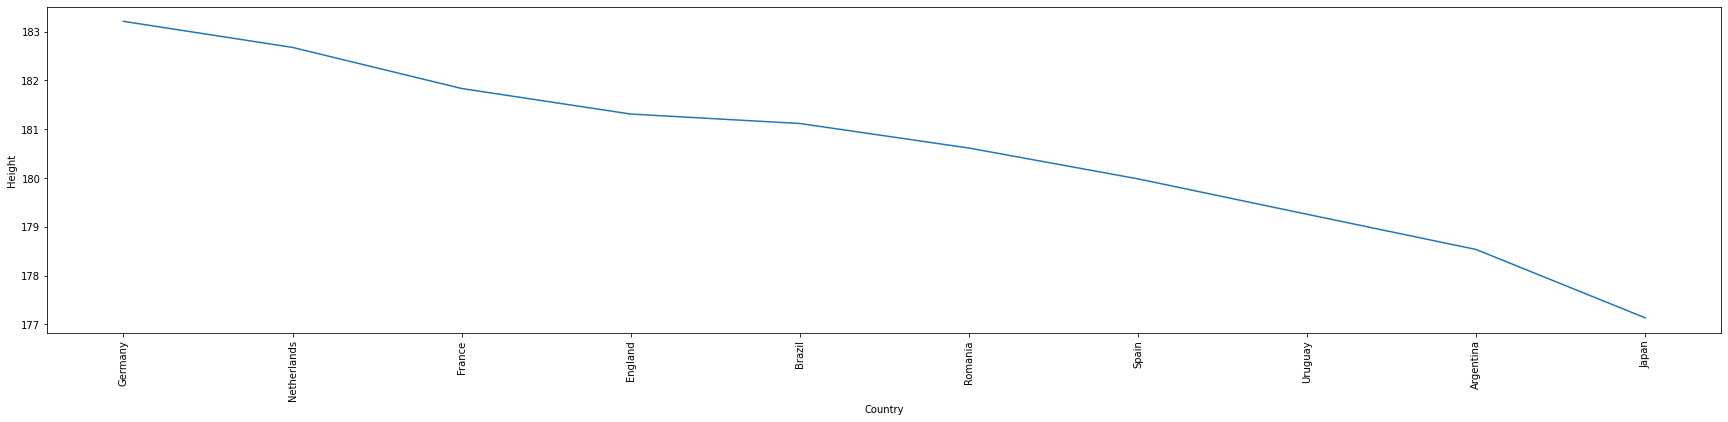

In [122]:
def plot_average_attr_country(df,n_top_countries,attribute):

    nations_group = df.groupby('Nationality')
    temp = [(nation,df1['Name'].count(),df1[attribute].sum()/df1[attribute].count()) for nation, df1 in nations_group]
    temp.sort(key=lambda x:x[1],reverse=True)
    
    if n_top_countries <= len(temp):
        temp2 = [(temp[i][0],temp[i][2]) for i in range(n_top_countries)]
        temp2.sort(key=lambda x:x[1],reverse=True) 
        top_countries = [temp2[i][0] for i in range(n_top_countries)]
        attr_value = [temp2[i][1] for i in range(n_top_countries)]
        plt.figure(figsize=(30,6))
        plt.xticks(rotation = 90)
        plt.plot(top_countries,attr_value)
        plt.xlabel(f'Country')
        plt.ylabel(f'{attribute}')
    
    else:
        print(f'chutiye itne desh hi nahi hai, {len(temp)} se kaam chalale\n')
        n_top_countries = len(temp)
        temp2 = [(temp[i][0],temp[i][2]) for i in range(n_top_countries)]
        temp2.sort(key=lambda x:x[1],reverse=True) 
        top_countries = [temp2[i][0] for i in range(n_top_countries)]
        attr_value = [temp2[i][1] for i in range(n_top_countries)]
        plt.figure(figsize=(30,6))
        plt.xticks(rotation = 90)
        plt.plot(top_countries,attr_value)
        plt.xlabel(f'Country')
        plt.ylabel(f'{attribute}')

plot_average_attr_country(df,10,'Height')